# **1. 데이터 및 라이브러리 불러오기**

참고 코드: 텐서플로2와 머신러닝으로 시작하는 자연어처리(위키북스)

https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 경로 설정
os.chdir('/content/drive/My Drive/[SCIC 2021] 삼성카드 공모전/2. 샘플 데이터')
os.getcwd()

'/content/drive/My Drive/[SCIC 2021] 삼성카드 공모전/2. 샘플 데이터'

In [3]:
!pip install transformers==3.0.2

     |████████████████████████████████| 769 kB 38.1 MB/s 
     |████████████████████████████████| 895 kB 58.6 MB/s 
     |████████████████████████████████| 3.0 MB 55.6 MB/s 
     |████████████████████████████████| 1.2 MB 55.7 MB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
import tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import log_loss, accuracy_score,f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import *

In [55]:
df = pd.read_csv("pororo_df85.csv")

In [56]:
df

,발화,우선순위
0,상담직원과 빠른연결했슴좋겠어요,5
1,안 기다리고 빨리 상담되었으면 좋겠다,5
2,너무 오래 기다리고 상담이 늦어져요,5
3,상담직원과 통화가 매우 힘들다,5
4,상담받으려면 오래 기다리는 게 불편함,5
...,...,...
995,카드 분실된 지 1분 만에 카드를 통해서 연락받아 바로 찾았어요 잃어버린지도 몰랐는...,11
996,수시로 6개월 무이자 할부와 링크 혜택이 다른 카드와 구별되는 기능이 편리함,7
997,무이자 할부 자주 많이 주셔서 감사합니다,7
998,무이자 혜택 만족 긴 할부 만족 잘 쓰고 있습니다,7


# **2. 데이터 전처리**

### 표본이 적은 범주 제거

In [57]:
class_label = df['우선순위'].value_counts()
small_list = class_label[class_label<=2].index

In [58]:
small_list

Int64Index([29, 35, 13, 11, 34, 12, 14, 19, 26, 31, 18], dtype='int64')

In [59]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state=0)

print(len(train))
print(len(test))

750
250


In [61]:
train = train[train['우선순위'].isin(small_list)==False]

In [74]:
n1 = test.shape[0]
test = test[test['우선순위'].isin(small_list)==False]

### class 재범주화

In [69]:
def switch(key):
  new = {"1" : 0, "2": 1, "4" : 2, "5" : 3, "7" : 4, "15" : 5, "23" : 6, "24" : 7, "25" : 8, "30" : 9, "32" : 10, 
         "33" : 11, "37" : 12, "41" : 13, "42" : 14, "43" : 15}.get(key, "default")
  return new

In [73]:
train = train.reset_index(drop=True, inplace=False)
train['new'] = np.nan
for i in range(len(train)):
  train['new'][i] = switch(train['우선순위'][i].astype(str))
train['new'] = train['new'].astype(int)
train = train.loc[:,['발화','new']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [76]:
test = test.reset_index(drop=True, inplace=False)
test['new'] = np.nan
for i in range(len(test)):
  test['new'][i] = switch(test['우선순위'][i].astype(str))
test['new'] = test['new'].astype(int)
test = test.loc[:,['발화','new']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [79]:
train['new'].value_counts().sort_index(ascending=True)

0     212
1      28
2     128
3      99
4       2
5       2
6      11
7      96
8      15
9      23
10      4
11    104
12      8
13      2
14      4
15      3
Name: new, dtype: int64

In [80]:
test['new'].value_counts().sort_index(ascending=True)

0     73
1      7
2     37
3     26
4      2
5      4
6      4
7     29
8      7
9     12
10     1
11    31
12     5
13     2
14     1
15     4
Name: new, dtype: int64

### **EDA**

In [81]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

(array([  4.,  16.,  62.,  84.,  97., 161.,  81., 106.,  39.,  31.,  41.,
         20.,  20.,  36.,  15.,  25.,  15.,  12.,  20.,   8.,  11.,   9.,
         11.,   9.,   7.,   6.,   5.,   4.,   5.,   5.,   8.,   4.,   6.,
          4.,   2.,   2.,   2.,   0.,   0.,   4.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.  ,   4.38,   6.76,   9.14,  11.52,  13.9 ,  16.28,  18.66,
         21.04,  23.42,  25.8 ,  28.18,  30.56,  32.94,  35.32,  37.7 ,
         40.08,  42.46,  44.84,  47.22,  49.6 ,  51.98,  54.36,  56.74,
         59.12,  61.5 ,  63.88,  66.26,  68.64,  71.02,  73.4 ,  75.78,
         78.16,  80.54,  82.92,  85.3 ,  87.68,  90.06,  92.44,  94.82,
         97.2 ,  99.58, 101.96, 104.34, 106.72, 109.1 , 111.48, 113.86,
        116.24, 118.62, 121.  ]),
 <a list of 50 Patch objects>)

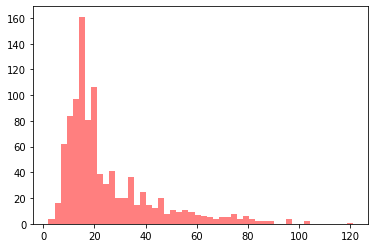

In [82]:
length = df['발화'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')

In [83]:
length.describe()

count    1000.0000
mean       25.0100
std        18.1322
min         2.0000
25%        13.0000
50%        18.0000
75%        31.0000
max       121.0000
Name: 발화, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0, flags=flags)


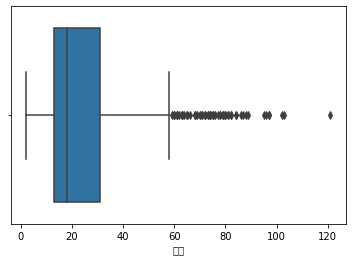

In [85]:
import seaborn as sns
sns.boxplot(length)

# **3. 모델링**

In [86]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)
BATCH_SIZE = 32
NUM_EPOCHS = 30
VALID_SPLIT = 0.2
MAX_LEN = 100

### **Bert Tokenizer**

In [95]:
from transformers import *
tokenizer=BertTokenizer.from_pretrained('bert-base-multilingual-cased',  cache_dir='bert_ckpt', do_lower_case=False)

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict=tokenizer.encode_plus(
    text = sent, 
    add_special_tokens=True, 
    max_length=MAX_LEN, 
    pad_to_max_length=True,
    truncation = True)
    
    input_id=encoded_dict['input_ids']
    
    return input_id

input_ids =[]
train_df_labels = []

for train_sent, train_label in zip(train['발화'], train['new']):
    try:
        input_id = bert_tokenizer(train_sent, MAX_LEN=MAX_LEN)
        input_ids.append(input_id) # input token
        train_df_labels.append(train_label) # input label
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_input_ids=np.array(input_ids, dtype=int)
train_labels=np.asarray(train_df_labels, dtype=np.int32)

In [96]:
print(train_input_ids[1])
print(tokenizer.decode(train_input_ids[1]))

[   101   9781  58931  11102   9414 105462  10530   8848  12945  15001
  35115  48345    102      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]
[CLS] 친절한 상담에 감사드립니다 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [59]:
#k = 420
#print(train_input_ids[k])
#print(train_attention_masks[k])
#print(train_token_type_ids[k])
#print(tokenizer.decode(train_input_ids[k]))

[   101   9521  31605  14279   9568  74322  18382   9069  12310 100699
  10739   9004  32537   8934  12965  48549    102      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[CLS] 안내원 연결까지 대기시간이 너무 길어요 [SEP] [PAD] [PAD] [

### **ADASYN**

In [97]:
from imblearn.over_sampling import *

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [98]:
X_imb = train_input_ids
y_imb = train['new']

In [99]:
X_samp, y_samp = ADASYN(n_neighbors=1).fit_sample(X_imb, y_imb)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [101]:
def convert_data(data_df):
  input_ids = data_df
  n = data_df.shape[0]
  attention_masks =[]
  token_type_ids =[]

  for i in range(n):
    token = input_ids[i]
    num_zeros = token.tolist().count(0)
    attention_mask = [1]*(MAX_LEN - num_zeros) + [0]*num_zeros
    token_type_id = [0]*MAX_LEN
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
  attention_masks = np.asarray(attention_masks, dtype=np.int32)
  token_type_ids = np.asarray(token_type_ids, dtype=np.int32)
  inputs = (input_ids, attention_masks, token_type_ids)
  return inputs

In [102]:
train_inputs = convert_data(X_samp)
train_labels = np.asarray(y_samp, dtype=np.int32)

In [103]:
train_labels

array([ 2,  0,  3, ..., 15, 15, 15], dtype=int32)

In [104]:
train_inputs

(array([[  101,  9521, 31605, ...,     0,     0,     0],
        [  101,  9781, 58931, ...,     0,     0,     0],
        [  101,  9568, 74322, ...,     0,     0,     0],
        ...,
        [  101,  9984, 15118, ...,     0,     0,     0],
        [  101,  9868, 18410, ...,     0,     0,     0],
        [  101,  9888, 17844, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32))

### **모델링**

In [108]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert_ckpt',
                             num_class=16)

# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model_name = "tf2_bert_classifier"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_inputs, train_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


tf2_bert_classifier -- Folder already exists 

Epoch 1/30
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
86/86 [==============================] - 76s 691ms/step - loss: 1.8625 - accuracy: 0.3929 - val_loss: 5.4472 - val_accuracy: 0.0029

Epoch 00001: val_accuracy improved from -inf to 0.00294, saving model to tf2_bert_classifier/weights.h5
Epoch 2/30
86/86 [==============================] - 59s 680ms/step - loss: 1.1403 - accuracy: 0.6210 - val_loss: 5.8747 - val_accuracy: 0.0015

Epoch 00002: val_accuracy did not improve from 0.00294
Epoch 3/30
86/86 [==============================] - 61s 706ms/step - loss: 0.8079 - accuracy: 0.7407 - val_loss: 6.0855 - val_accuracy: 0.0015

Epoch 00003: val_accuracy did not improve from 0.00294
Epoch 4/30
86/86 [==============================] - 60s 703ms/step - loss: 0.5692 - accuracy: 0.8160 - val_loss: 6.2100 - val_accuracy: 0.0015

Epoch 00004: val_accuracy

In [109]:
input_ids =[]
train_data_labels = []

for test_sent in test['발화']:
    try:
        input_id = bert_tokenizer(test_sent, MAX_LEN=MAX_LEN)
        input_ids.append(input_id)
       
    except Exception as e:
        print(e)
        print(test_sent)
        pass
    
test_input_ids=np.array(input_ids, dtype=int)

In [110]:
test_inputs = convert_data(test_input_ids)

In [111]:
results = cls_model.predict(test_inputs)
test['pred'] = tf.argmax(results, axis=1)

In [112]:
accuracy_score(test['new'], test['pred'])

0.8326530612244898

In [119]:
sum(test['new']==test['pred'])/n1 # real accuracy

0.816

In [43]:
test[test['new']!=test['pred']]

,발화,new,pred
436,나 같이 메일이나 앱을 못하는 사람을 위해 비밀번호와 생년월일을 한 번만 입력해 놓...,11,10
295,삼성은 이 나라의 축이다 최선을 다해주길,13,6
294,불만이 너무 많아요,14,3
843,밤늦게까지 상담해주셔서 감사합니다,7,1
412,전화통화 시 상담원과의 통화가 되기까지 거치는 단계가 없이 연결되었으면 합니다,11,3
982,수시로 6개월 무이자 할부와 링크 혜택이 다른 카드와 구별되는 기능이 편리함,4,8
304,전화가 너무 많이 걸 여옵니다,12,1
960,국민카드는 혜택사항을 매달 알려주고 빠르게 처리해줘서 항상 감사하게 쓰고 있습니다,7,1
279,나이 많은 경 노인들께 좀 큰 목소리를 하고 알아먹기 좋은 말로 친절하게 대답해주어...,2,7
308,삼성카드는 그렇지 않겠지만 타 카드 회사는 보험회사와 연결되는 전화가 오는 경우가 ...,12,6


## 후처리

In [113]:
def switch_again(val):
  new = {"1" : 0, "2": 1, "4" : 2, "5" : 3, "7" : 4, "15" : 5, "23" : 6, "24" : 7, "25" : 8, "30" : 9, "32" : 10, 
         "33" : 11, "37" : 12, "41" : 13, "42" : 14, "43" : 15}
  for key, value in new.items():
    if val == value:
      return key

In [114]:
int(switch_again(5))

15

In [115]:
test = test.reset_index(drop=True, inplace=False)
test['pred_real'] = np.nan
for i in range(len(test)):
  test['pred_real'][i] = int(switch_again(test['pred'][i]))
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,발화,new,pred,pred_real
0,상담 감사해요,7,7,24.0
1,너무 회사 위주이고 고객은 삼성동이다,13,6,23.0
2,골드회원에 대한 상담 서비스 우대,1,1,2.0
3,친절한 상담에 감사드립니다,0,0,1.0
4,삼성카드가 제일 전문적이고 정확하다,6,7,24.0
...,...,...,...,...
240,연회비 면제 카드로 알고 사용했는데 연회비를 슬쩍 청구하네요 참나,9,9,30.0
241,보이는 대기화면에 상담원 연결 표시가 파란색이지만 쉽게 한눈에 찾기가 힘듦,11,11,33.0
242,너무 오래 기다리고 상담이 늦어져요,3,3,5.0
243,연회비 업으면 좋겠어요,9,9,30.0


In [116]:
class_ind = pd.read_excel("공모전_제공_데이터(1차).xlsx", sheet_name = '우선순위')
class_ind

,우선순위,의도명(유형)
0,1,칭찬>고객서비스>상담원
1,2,칭찬>고객서비스>상담시스템
2,3,칭찬>고객서비스
3,4,불만>고객서비스>상담원
4,5,불만>고객서비스>상담시스템
5,6,불만>고객서비스
6,7,칭찬>삼성카드>혜택
7,8,칭찬>삼성카드>할부금융상품
8,9,칭찬>삼성카드>커뮤니티서비스
9,10,칭찬>삼성카드>카드이용/결제


In [117]:
test_df = pd.merge(test,class_ind, how='left', left_on='pred_real', right_on='우선순위')
test_df = test_df.loc[:,['발화','의도명(유형)']]
test_df

,발화,의도명(유형)
0,상담 감사해요,칭찬>기타
1,너무 회사 위주이고 고객은 삼성동이다,칭찬>삼성카드
2,골드회원에 대한 상담 서비스 우대,칭찬>고객서비스>상담시스템
3,친절한 상담에 감사드립니다,칭찬>고객서비스>상담원
4,삼성카드가 제일 전문적이고 정확하다,칭찬>기타
...,...,...
240,연회비 면제 카드로 알고 사용했는데 연회비를 슬쩍 청구하네요 참나,불만>삼성카드>청구입금
241,보이는 대기화면에 상담원 연결 표시가 파란색이지만 쉽게 한눈에 찾기가 힘듦,불만>삼성카드>상담/채널
242,너무 오래 기다리고 상담이 늦어져요,불만>고객서비스>상담시스템
243,연회비 업으면 좋겠어요,불만>삼성카드>청구입금
